In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

## Load Data and fix Party_Code mistakes and create column indicating D or R for all rows, inferred and real 

In [2]:
# Load the dataset again
data = pd.read_csv('data/surveydata.csv')

corrected_data = data.copy()


# Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

# Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
states_to_update = ['DC', 'LA', 'RI']
corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'

# Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'


#categorical_columns
# Create a mapping dictionary for PARTY_CODE to INFER_PARTY values
party_mapping = {
    'D': 'D',
    'E': 'D',
    'R': 'R',
    'S': 'R',
    'N': float('nan'),
    'U': float('nan'),
    'A': float('nan'),
    'B': float('nan'),
    'C': float('nan'),
    'F': float('nan'),
    'G': float('nan'),
    'H': float('nan'),
    'I': float('nan'),
    'J': float('nan'),
    'K': float('nan'),
    'L': float('nan'),
    'P': float('nan'),
    'Q': float('nan'),
    'T': float('nan'),
    'V': float('nan'),
    'W': float('nan'),
    'Y': float('nan'),
    'Z': float('nan'),
    'O': float('nan'),
}

# Create the INFER_PARTY column using the mapping
corrected_data['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(party_mapping)

print(corrected_data['PARTY_CODE'].unique())


# Display the unique values in the INFER_PARTY column to ensure correctness
unique_infer_party = corrected_data['INFER_PARTY'].unique()

print('unique_infer_party:')

print(unique_infer_party)

# Define the mapping for PARTY_CODE modifications
party_code_mapping = {
    'E': float('nan'),
    'S': float('nan'),
    'U': float('nan'),
    'A': 'O',
    'B': 'O',
    'C': 'O',
    'F': 'O',
    'G': 'O',
    'H': 'O',
    'I': 'O',
    'J': 'O',
    'K': 'O',
    'L': 'L',
    'P': 'O',
    'Q': 'O',
    'T': 'O',
    'V': 'O',
    'W': 'O',
    'Y': 'O',
    'Z': 'O'
}

# Apply the mapping to the PARTY_CODE column
corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)

# Check the unique values of PARTY_CODE after the modifications
unique_party_code_after_modifications = corrected_data['PARTY_CODE'].unique()

print("unique_party_code_after_modifications:")

print(unique_party_code_after_modifications)


['E' 'R' 'D' 'N' 'U' 'S' 'Z' 'I' 'Y' 'O' 'L']
unique_infer_party:
['D' 'R' nan]
unique_party_code_after_modifications:
[nan 'R' 'D' 'N' 'O' 'L']


## Feature Engineering
#### By far the biggest difference in performance has come from the "INFER_PARTY" column I created above, while the following feature engineering tweeks eeked out an additional 2-3 percent of accuracy depending on the model below (and sometimes an increase in one model's accuracy came at the expense of another's). 

In [3]:

# print("unique values")
# print(len(corrected_data['COUNTY_ST'].unique()))

# print("NaN values")
# print((corrected_data['COUNTY_ST'].isna()).sum())

# print("count")
# print(len(corrected_data['COUNTY_ST']))

# # Extract columns of type 'object'
# # data['TOD_PRES_O_2016']

# print((corrected_data['COUNTY_ST'].unique()))


In [4]:
engineered_data = corrected_data.copy()

tod_pres_diff_cols = [col for col in engineered_data.columns if col.startswith('TOD_PRES_DIFF')]

# Convert 'TIE' values to 0 for all 'TOD_PRES_DIFF' columns
engineered_data[tod_pres_diff_cols] = engineered_data[tod_pres_diff_cols].replace('TIE', 0)

# Apply the transformation to each of the 'TOD_PRES_DIFF' columns
for col in tod_pres_diff_cols:
    # Skip if the column has already been converted (e.g. TOD_PRES_DIFF_2016)
    if engineered_data[col].dtype != 'object':
        continue
    
    # Extract numerical margin and party character
    margin_num = engineered_data[col].str[:-1].astype(float)
    party_char = engineered_data[col].str[-1]
    
    # Create the signed margin column
    signed_margin = margin_num.where(party_char == 'D', -margin_num)  # Positive for D, negative for R
    engineered_data[col] = signed_margin

# Display the first few rows of the transformed columns to verify the transformation
engineered_data[tod_pres_diff_cols].head()

,TOD_PRES_DIFF_2016,TOD_PRES_DIFF_2016_PREC,TOD_PRES_DIFF_2020_PREC
0,23.0,20.0,32.0
1,-14.0,-25.0,-24.0
2,48.0,5.0,NaN
3,-34.0,-31.0,-24.0
4,7.0,1.0,8.0


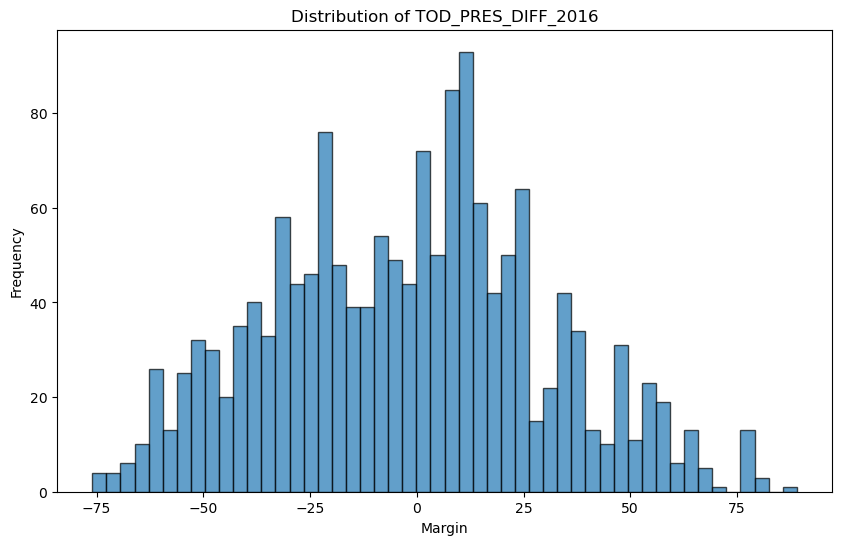

In [5]:
import matplotlib.pyplot as plt

# Plotting the distribution of the 'TOD_PRES_DIFF_2016' column as an example
plt.figure(figsize=(10, 6))
engineered_data['TOD_PRES_DIFF_2016'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of TOD_PRES_DIFF_2016')
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [6]:
# Define bin edges and labels
bin_edges = [-float('inf'),-50,-25,-10,-5,1,5,10,25,50, float('inf')]
labels = [-7,-5,-3,-2,-1,1,2,3,5,7]

# Apply the binning for each 'TOD_PRES_DIFF' column
for col in tod_pres_diff_cols:
    engineered_data[col] = pd.cut(engineered_data[col], bins=bin_edges, labels=labels, ordered=False)
# Display the first few rows of the binned columns
engineered_data[[col for col in tod_pres_diff_cols]].head()

,TOD_PRES_DIFF_2016,TOD_PRES_DIFF_2016_PREC,TOD_PRES_DIFF_2020_PREC
0,3,3,5
1,-3,-5,-3
2,5,1,NaN
3,-5,-5,-3
4,2,-1,2


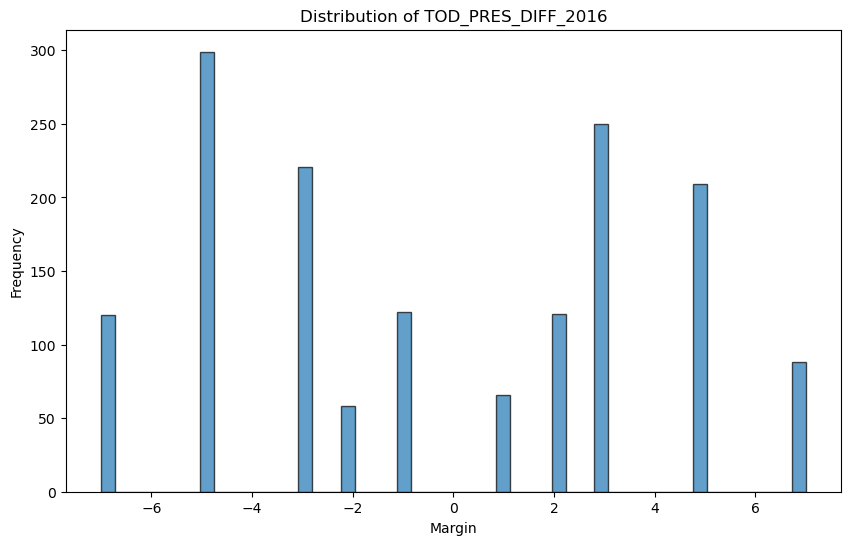

In [7]:
import matplotlib.pyplot as plt

# Plotting the distribution of the 'TOD_PRES_DIFF_2016' column as an example
plt.figure(figsize=(10, 6))
engineered_data['TOD_PRES_DIFF_2016'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of TOD_PRES_DIFF_2016')
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [8]:
voter_columns = [col for col in engineered_data.columns if col.startswith("VTR")]

#Create column with total number of votes in voter_columns per row
engineered_data['VTR_TOTAL_VOTES'] = engineered_data[voter_columns].notnull().sum(axis=1)

#Sum Democrat and Republican totals
engineered_data['VTR_TOTAL_DVOTES'] = engineered_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
engineered_data['VTR_TOTAL_RVOTES'] = engineered_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)

#Create conditions that evaluate whether more votes have been cast for Democrats or Republicans, and assign 'D' and 'R' to new column based on conditions
conditions = [
    engineered_data['VTR_TOTAL_DVOTES'] > engineered_data['VTR_TOTAL_RVOTES'],
    engineered_data['VTR_TOTAL_DVOTES'] < engineered_data['VTR_TOTAL_RVOTES']
]

choices = ['D', 'R']

engineered_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)

#Create conditions that evaluate whether a voter is a swing voter or not
conditions_swing = [
    (engineered_data['VTR_TOTAL_DVOTES'] > 2) & (engineered_data['VTR_TOTAL_RVOTES'] > 2),
    ((engineered_data['VTR_TOTAL_DVOTES'] > 1) & (engineered_data['VTR_TOTAL_RVOTES'] == 0)) | ((engineered_data['VTR_TOTAL_RVOTES'] > 1) & (engineered_data['VTR_TOTAL_DVOTES'] == 0))
]

choices_swing = ['Y', 'N']

engineered_data['VTR_INFER_SWING'] = np.select(conditions_swing, choices_swing, default=np.nan)

#sampledf = engineered_data[['PARTY_CODE','INFER_PARTY','VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY','VTR_INFER_SWING']]
#print(sampledf.head(50))

#Add values to INFER_PARTY and correct any other INFER_PARTY values that don't meet the conditions above:
print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before

engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'D'
engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'R'

#Also delete any 'D' or 'R' INFER_PARTY labels for anyone deemed a "swing voter" based on criteria above of voting for both parties at least 3 times each:
engineered_data.loc[(engineered_data['VTR_INFER_SWING'] == 'Y') , 'INFER_PARTY'] = float('nan')

print(sum(engineered_data['INFER_PARTY'].isna())) #297 NaNs for INFER_PARTY after

#Drop auxiliary columns used for math, keeping 'VTR_TOTAL_VOTES', 'VTR_INFER_SWING', and the updated 'INFER_PARTY' columns as features:
engineered_data = engineered_data.drop(columns=['VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY'])


291
283


In [9]:
data = engineered_data


## Predicting who is planning on voting Republican vs Democrat 

#### Using selected features (columns that begin with "PRF", "DON", "VTR", "PARTY", "TOD", and our engineered feature "INFER_PARTY").
#### For some reason when working with these features and this prediction task I achieve better performance imputing all missing values. In all the other examples below I achieved better performance without imputing

In [10]:
# Select columns based on the specified prefixes
# This list comprehension will go through each column in the data and 
# check if its name starts with any of the specified prefixes.
selected_columns = [col for col in data.columns if col.startswith(("PRF","DON", "VTR", "TOD", 'PARTY','Q1_','INFER_P'))]

# Filter the data to only include the selected columns and the 'Q1_Candidate' column
filtered_data = data[selected_columns]

# Create a binary target variable:
# We are marking candidates 'President Joe Biden','Marianne Williamson', and 'Robert F. Kennedy Jr.' as class 0
# All other candidates will be considered as class 1.
filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x in ['President Joe Biden','Marianne Williamson','Robert F. Kennedy Jr.'] else 1)

# Splitting the dataset:
# We're splitting the data into features (X) and target (y).
# The 'target' and 'Q1_Candidate' columns are excluded from features.
# 80% of the data is used for training and 20% for testing.
X = filtered_data.drop(columns=['target', 'Q1_Candidate'])  # Features (excluding 'target' and 'Q1_Candidate')
y = filtered_data['target']                                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns and convert their data type to string.
# This ensures that the subsequent preprocessing steps treat them as categorical variables.
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Preprocessing setup:
# For categorical columns:
# 1. Impute missing values with the most frequent value in the column.
# 2. One-hot encode the categorical columns to convert them to a numerical format.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# For numerical columns:
# Impute missing values with the mean of the column.
numerical_transformer = SimpleImputer(strategy='mean')

# Combine the categorical and numerical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.select_dtypes(exclude=['object', 'category']).columns),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessing steps to the training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Model Training:
# Use Gradient Boosting Classifier for prediction.
gbm_classifier = GradientBoostingClassifier(random_state=42)
gbm_classifier.fit(X_train_preprocessed, y_train)

# Making Predictions and Evaluation:
# Predict the target values for the test set and evaluate the model's performance using accuracy and a classification report.
y_pred = gbm_classifier.predict(X_test_preprocessed)
accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)



C:\Users\Hernando\AppData\Local\Temp\ipykernel_7932\2782744653.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x in ['President Joe Biden','Marianne Williamson','Robert F. Kennedy Jr.'] else 1)


0.8012820512820513
              precision    recall  f1-score   support

           0       0.81      0.60      0.69       114
           1       0.80      0.92      0.85       198

    accuracy                           0.80       312
   macro avg       0.80      0.76      0.77       312
weighted avg       0.80      0.80      0.79       312



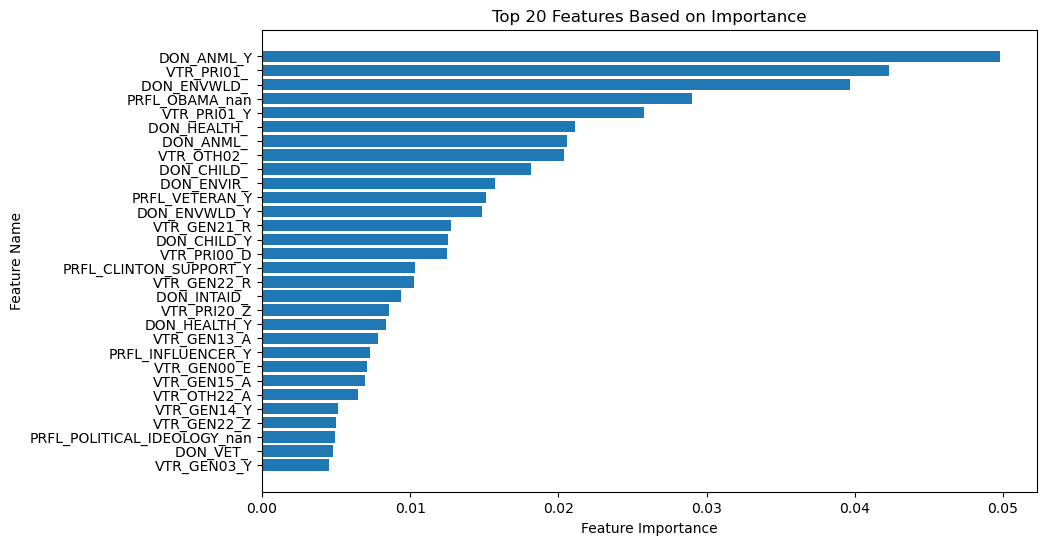

In [11]:
# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names after preprocessing (post one-hot encoding)
feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:30]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()


#### Model with only voter data (columns that begin with "VTR", and "TOD", and our engineered feature "INFER_PARTY"):

#### This model performed better without imputing values, as did all the following models

In [12]:



# Select columns based on the specified prefixes
selected_columns = [col for col in data.columns if col.startswith(( "VTR", 'TOD','Q1_','INFER_P'))]

# Extract the selected columns along with the 'target' column
filtered_data = data[selected_columns]

# Create the binary target variable
filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x in ['President Joe Biden','Marianne Williamson','Robert F. Kennedy Jr.'] else 1)

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'Q1_Candidate'])  # Features (excluding 'target' and 'Q1_Candidate')
y = filtered_data['target']                                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns to string type
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Preprocessing for Categorical Data Only (we do not impute any values this time)
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# GBM Classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)
gbm_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = gbm_classifier.predict(X_test_preprocessed)
accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)



C:\Users\Hernando\AppData\Local\Temp\ipykernel_7932\3015352379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x in ['President Joe Biden','Marianne Williamson','Robert F. Kennedy Jr.'] else 1)


0.7852564102564102
              precision    recall  f1-score   support

           0       0.80      0.55      0.65       114
           1       0.78      0.92      0.84       198

    accuracy                           0.79       312
   macro avg       0.79      0.74      0.75       312
weighted avg       0.79      0.79      0.77       312



#### Notice how different the features used by the two models are despite their similar scores

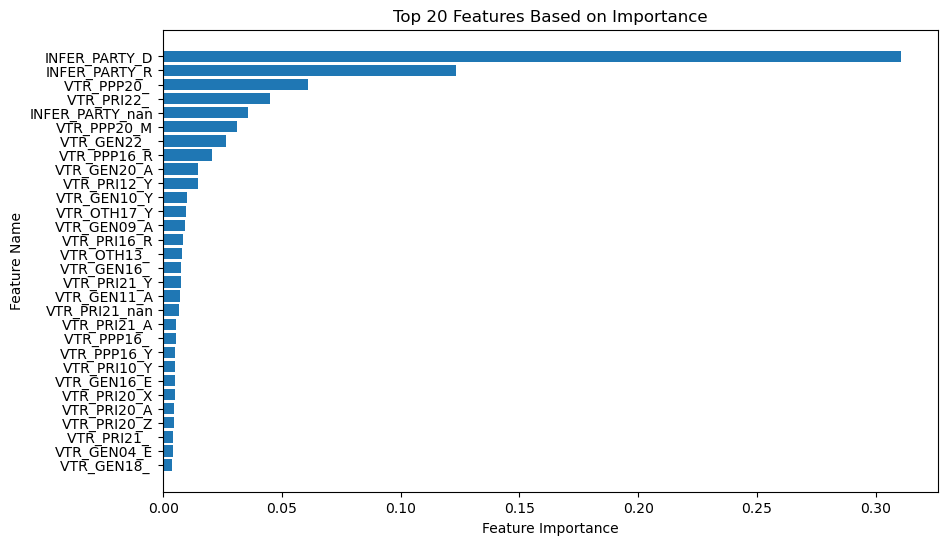

In [13]:
# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names after preprocessing (post one-hot encoding)
feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:30]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

## Predicting which Republican supporters support Trump vs other Republican candidates
#### with selected features (columns that begin with "PRF", "DON", "VTR", "TOD", "PARTY_CODE, and our engineered feature "INFER_PARTY"):

In [14]:
#Select columns based on the specified prefixes
selected_columns = [col for col in data.columns if col.startswith(("PRF", "DON", "VTR", "TOD",'PARTY_C','Q1_','INFER_P'))]

# Extract the selected columns along with the 'target' column
filtered_data = data[selected_columns]

# Filter out respondents who said they would vote for ‘President Joe Biden’, ‘Robert F. Kennedy Jr.’, or ‘Marianne Williamson’
filtered_data = filtered_data[~filtered_data['Q1_Candidate'].isin(['President Joe Biden', 'Robert F. Kennedy Jr.', 'Marianne Williamson'])]

# Create the binary target variable
filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x == 'President Donald Trump' else 1)

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'Q1_Candidate'])  # Features (excluding 'target' and 'Q1_Candidate')
y = filtered_data['target']                                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Convert all categorical columns to string type
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Preprocessing for Categorical Data Only
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])


# Preprocess training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Initialize and train the GBM classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)
gbm_classifier.fit(X_train_preprocessed, y_train)

# Predict on the test set
y_pred = gbm_classifier.predict(X_test_preprocessed)

# Evaluate the model's performance
accuracy_all_columns = accuracy_score(y_test, y_pred)
classification_rep_all_columns = classification_report(y_test, y_pred)

print("""Predicting Trump vs other Repub candidates with "PRF", "DON", "VTR", and "TOD" columns""")
print(accuracy_all_columns) 
print(classification_rep_all_columns)

Predicting Trump vs other Repub candidates with "PRF", "DON", "VTR", and "TOD" columns
0.625
              precision    recall  f1-score   support

           0       0.64      0.61      0.63       103
           1       0.61      0.64      0.62        97

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.63       200



#### Once again, notice the difference in features between this model and the one below that uses more limited features but achieves even better performance

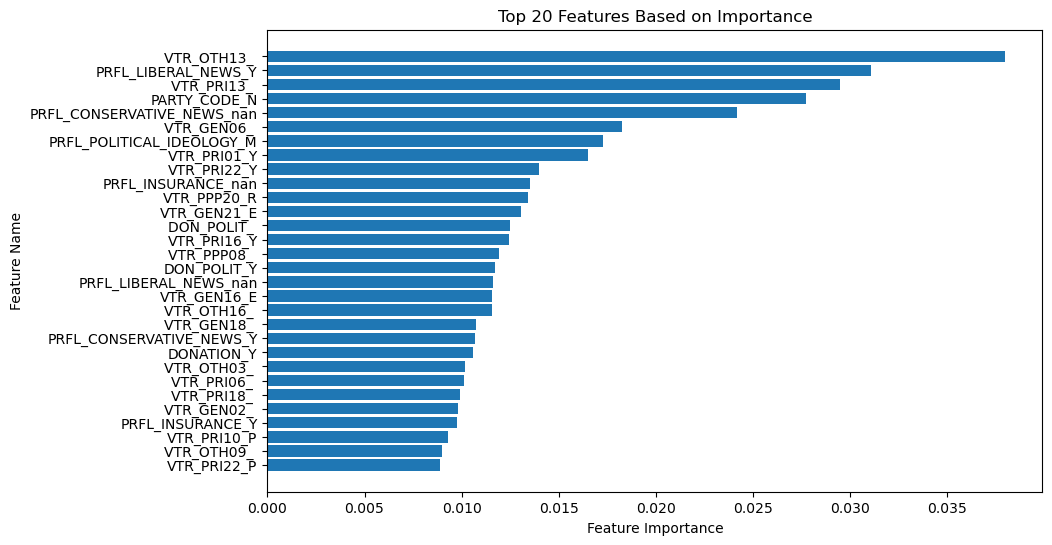

In [15]:

# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names after preprocessing (post one-hot encoding)
feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:30]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()


#### Using only voter data (columns that begin with "VTR", and "TOD" and our engineered feature "INFER_PARTY"):

In [16]:
# Select columns based on the specified prefixes
selected_columns = [col for col in data.columns if col.startswith(("VTR", "TOD",'INFER_P','Q1_'))]

# Extract the selected columns along with the 'target' column
filtered_data = data[selected_columns]

# Filter out respondents who said they would vote for ‘President Joe Biden’, ‘Robert F. Kennedy Jr.’, or ‘Marianne Williamson’
filtered_data = filtered_data[~filtered_data['Q1_Candidate'].isin(['President Joe Biden', 'Robert F. Kennedy Jr.', 'Marianne Williamson'])]

# Create the binary target variable
filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x == 'President Donald Trump' else 1)

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'Q1_Candidate'])  
y = filtered_data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns to string type
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Preprocessing for Categorical Data Only
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# GBM Classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)
gbm_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = gbm_classifier.predict(X_test_preprocessed)
accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)

0.635
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       103
           1       0.64      0.58      0.61        97

    accuracy                           0.64       200
   macro avg       0.64      0.63      0.63       200
weighted avg       0.64      0.64      0.63       200



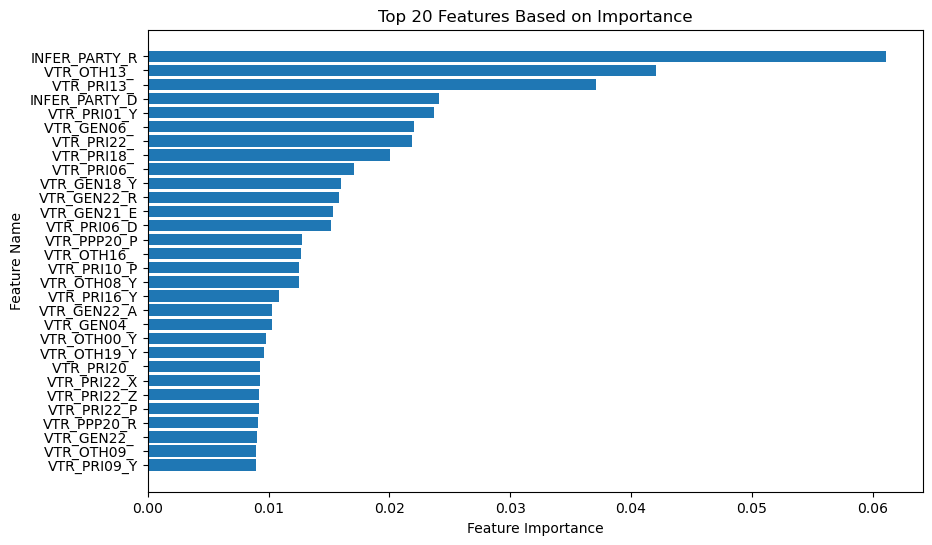

In [17]:


# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names after preprocessing (post one-hot encoding)
feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:30]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

## Predicting 3 classes of voters: Biden voters, Trump voters, and Other Republican voters
#### with selected features (columns that begin with "PRF", "DON", "VTR", "TOD", "PARTY", and our engineered feature "INFER_PARTY"):

In [18]:


# Filter out potential data leakage columns
selected_columns = [col for col in data.columns if col.startswith(("PRF", "DON", "VTR", "TOD",'PARTY_','INFER_P','Q1_'))]

# Extract the selected columns along with the 'target' column
filtered_data = data[selected_columns]

# Create the binary target variable
filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x in ['President Joe Biden', 'Marianne Williamson', 'Robert F. Kennedy Jr.'] else (1 if x == 'President Donald Trump' else 2))

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'Q1_Candidate'])  
y = filtered_data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns to string type
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Preprocessing for Categorical Data Only
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# GBM Classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)
gbm_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = gbm_classifier.predict(X_test_preprocessed)
accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)

C:\Users\Hernando\AppData\Local\Temp\ipykernel_7932\3442305895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['target'] = filtered_data['Q1_Candidate'].apply(lambda x: 0 if x in ['President Joe Biden', 'Marianne Williamson', 'Robert F. Kennedy Jr.'] else (1 if x == 'President Donald Trump' else 2))


0.6089743589743589
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       114
           1       0.57      0.64      0.60       106
           2       0.51      0.39      0.44        92

    accuracy                           0.61       312
   macro avg       0.60      0.60      0.59       312
weighted avg       0.60      0.61      0.60       312



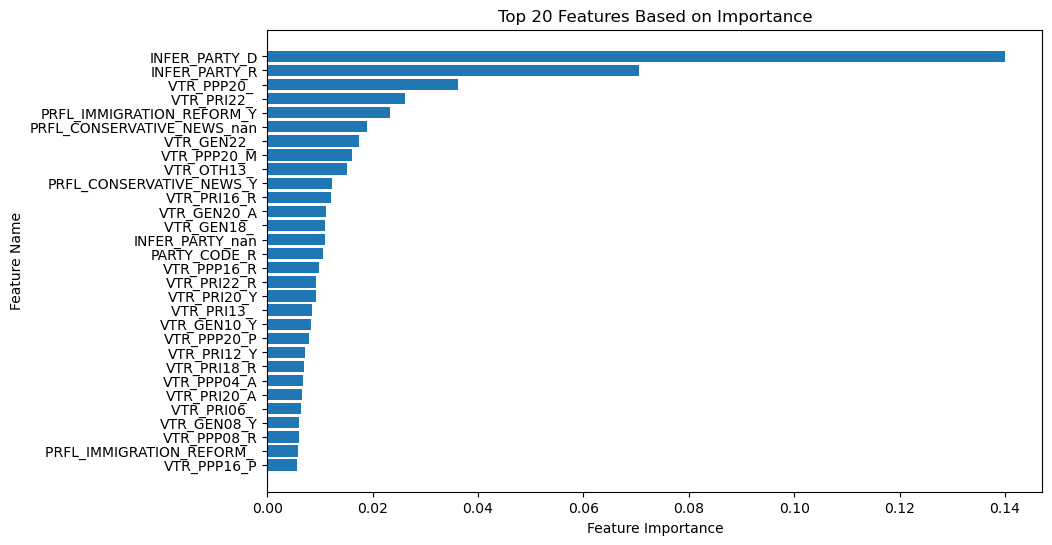

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names after preprocessing (post one-hot encoding)
feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:30]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()